# Explore atlases

## Load rs-fMRI dataset

### Use Nilearn to fetch developmental fMRI data

In [1]:
from nilearn import datasets

# Add dataset to Original_Data and include all confounds
data = datasets.fetch_development_fmri(data_dir='../Original_Data', reduce_confounds=False)

### Create DataLad dataset for raw developmental fMRI data

In [54]:
from datalad import api

api.create(path='../Original_Data', force=True)

### Save state of DataLad dataset

In [55]:
api.save(path='../Original_Data', message='Fetch development_fMRI dataset using Nilearn and create DataLad dataset')

### Create DataLad dataset for data generated by analysis

In [56]:
api.create(path='../Analysis_Data', force=True)

### Save state of DataLad dataset

In [57]:
api.save(path='../Analysis_Data', message='Create DataLad dataset for data generated by analysis')

## Load phenotypic information

In [2]:
import pandas

pheno = pandas.DataFrame(data.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


### Assess class balance

In [3]:
# Assign Age to variable
y_age = pheno['Age']

# Assign AgeGroup to variable and check counts of each age group
age_class = pheno['AgeGroup']
age_class.value_counts()

8-12yo    34
5yo       34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64

## Functional atlas

### Load BASC multiscale atlas

In [4]:
# Load atlas with 64 ROIs
parcellations_basc = datasets.fetch_atlas_basc_multiscale_2015(data_dir='../Original_Data')
atlas_filename_basc = parcellations_basc.scale064

In [61]:
# Save state of DataLad dataset
api.save(path='../Original_Data/basc_multiscale_2015', message='Download BASC multiscale atlas')

### Plot atlas

PermissionError: [Errno 13] Permission denied: '../Analysis_Data/BASC.png'

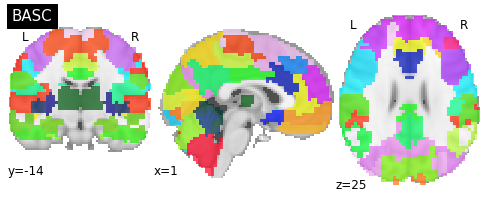

In [5]:
from nilearn import plotting

# Plot atlas
display = plotting.plot_roi(atlas_filename_basc, draw_cross=False, title="BASC")
# Save atlas plot
display.savefig('../Analysis_Data/BASC.png')

### Feature extraction for computing correlation matrices

In [ ]:
# Define function for initializing label masker
def mask_init_labels(atlas):
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, 
                           memory='nilearn_cache', verbose=0)
    return masker

In [ ]:
# Define function for initializaing connectivity measure
def corr_measure(diag):
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, # Set to vectorize
                                         discard_diagonal=diag)               # Keep/Discard diagonal
    return correlation_measure

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=False)

In [ ]:
# Define function to extract features for visualization of individual correlation matrices
def feat_extract_corr(masker, correlation_measure):
    all_features = [] # Empty list for containing all features (correlations)
    
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=data.confounds[i])
        # Create region x region correlation matrix
        correlation_matrix_ind = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix_ind)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        # Convert vectorized matrix to symmetric matrix
        ind_matrices = vec_to_sym_matrix(X_features)
        
    return time_series, ind_matrices

In [ ]:
from nilearn.connectome import vec_to_sym_matrix
import numpy as np

# Extract features for generatin of individual correlation matrices
time_series_BASC_all, ind_matrices_BASC_all = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix for subject

In [ ]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices_BASC_all[subject], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_BASC_all[subject], figure=(10, 8),   
                     labels=range(time_series_BASC_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/BASC_corr.png')

### Plot connectome

In [ ]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename_basc)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_BASC_all[subject], coordinates,
                         edge_threshold="80%",
                         title='BASC Atlas')
# Save connectome plot
display.savefig('../Analysis_Data/BASC_connectome.png')

### Feature extraction for model

In [63]:
# Define function to extract features for support vector regression model
def feat_extract_model(masker, correlation_measure):
    all_features = [] # Empty list for containing all features (correlations)
    
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=data.confounds[i])
        # Create region x region correlation matrix
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        
    return X_features

In [64]:
# Perform feature extraction
correlation_measure = corr_measure(diag=True)

X_features_BASC_all = feat_extract_model(masker, correlation_measure)

NameError: name 'corr_measure' is not defined

### Plot feature matrix

In [65]:
import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('Feature matrix')
plt.xlabel('Features')
plt.ylabel('Subjects')

NameError: name 'X_features' is not defined

### Define model for age prediction

In [66]:
from sklearn.svm import SVR
l_svr = SVR(kernel='linear')

### Generate training/validation splits

In [67]:
# Define function for generating training/validation splits
# Split sample to training/validation with a 75/25 ratio
# Stratify by age class, shuffle data

def train_val(X_features, y_age, age_class):
    n_splits = 10

    X_train_container = []
    X_val_container = []
    y_train_container = []
    y_val_container = []

    for i in range(n_splits):
        X_train, X_val, y_train, y_val = train_test_split(
                                                        X_features, # x
                                                        y_age, # y
                                                        test_size = 0.25, # 75%/25% split  
                                                        shuffle = True, # Shuffle dataset
                                                                        # before splitting
                                                        stratify = age_class,  # keep
                                                                               # distribution
                                                                               # of ageclass
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                                           )

        X_train_container.append(X_train)
        X_val_container.append(X_val)
        y_train_container.append(y_train)
        y_val_container.append(y_val)
    
    # Print size of our training and test groups
    print('training:', len(X_train),
         'testing:', len(X_val))
    
    return X_train_container, X_val_container, y_train_container, y_val_container

In [68]:
from sklearn.model_selection import train_test_split

X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_all, y_age, age_class)

NameError: name 'X_features_BASC_all' is not defined

### Fit model to training data using 10-fold CV

In [69]:
# Define function for fitting model to training data using 10-fold cross-validation

def model_fit(X_train_container, y_train_container):
    # Build a tiny pipeline that does feature selection (top 20% of features), 
    # and then prediction with our linear svr model.
    model = Pipeline([
        ('feature_selection',SelectPercentile(f_regression,percentile=20)),
        ('prediction', l_svr)
                     ])
    y_pred_all = []
    y_index_all = []

    for j in range(len(X_train_container)):

        y_pred = [] # Container to catch predictions from each fold
        y_index = [] # Index for each prediction

        # First we create 10 splits of the data
        skf = KFold(n_splits=10, shuffle=True, random_state=123)

        # For each split, assemble the train and test samples 
        for tr_ind, te_ind in skf.split(X_train_container[j]):
            X_tr = X_train_container[j][tr_ind]
            y_tr = y_train_container[j].values[tr_ind]
            X_te = X_train_container[j][te_ind]
            y_index += list(te_ind) # Store the index of samples to predict
    
            # Run pipeline 
            model.fit(X_tr, y_tr) # Fit data to the model using mini pipeline
            predictions = model.predict(X_te).tolist() # Get predictions for this fold
            y_pred += predictions # Add to list of predictions
        
        y_index_all.append(y_index)
        y_pred_all.append(y_pred)
        
    return y_index_all, y_pred_all

In [70]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

NameError: name 'X_train_container' is not defined

### Evaluate model using accuracy and mean absolute error

In [71]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'y_pred_all' is not defined

In [ ]:
# Decide whether or not this needs to be saved
import scipy.io as sio

#sio.savemat('atlas1.mat', {'y_pred_all': y_pred_all[k], 'y_train_container': np.array(y_train_container)[k][y_index_all[k]]})

## Structural atlas

### Load AAL atlas

In [72]:
# Load atlas
parcellations_aal = datasets.fetch_atlas_aal(data_dir='../Original_Data')
atlas_filename_aal = parcellations_aal.maps

In [73]:
# Save state of DataLad dataset
#api.save(path='../Original_Data/aal_SPM12', message='Download AAL atlas')

### Plot atlas

PermissionError: [Errno 13] Permission denied: '../Analysis_Data/AAL.png'

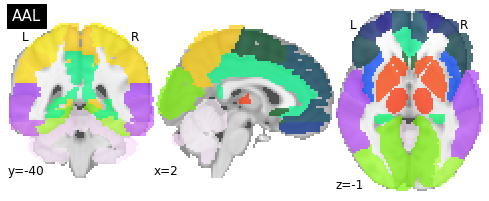

In [74]:
# Plot atlas
display = plotting.plot_roi(atlas_filename_aal, draw_cross=False, title="AAL")
# Save atlas plot
display.savefig('../Analysis_Data/AAL.png')

### Feature extraction for computing correlation matrices

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series_AAL_all, ind_matrices_AAL_all = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix

In [ ]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices_AAL_all[subject], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_AAL_all[subject], figure=(10, 8),   
                     labels=range(time_series_AAL_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/AAL_corr.png')

### Plot connectome

In [ ]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename_aal)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_AAL_all[subject], coordinates,
                         edge_threshold="80%",
                         title='AAL Atlas')
# Save connectome plot
display.savefig('../Analysis_Data/AAL_connectome.png')

### Perform SVR analysis

In [ ]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features_AAL_all = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [ ]:
import scipy.io as sio

#sio.savemat('atlas2.mat', {'y_pred_all1': y_pred_all[k], 'y_train_container1': np.array(y_train_container)[k][y_index_all[k]]})


## Clustering method atlas

### Load CRAD atlas

In [75]:
# Load atlas
parcellations_crad = datasets.fetch_atlas_craddock_2012(data_dir='../Original_Data')
atlas_filename_crad = parcellations_crad.random

In [76]:
# Save state of DataLad dataset
#api.save(path='../Original_Data/craddock_2012', message='Download Craddock atlas')

### Plot atlas

/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/Users/Storme/anaconda3/envs/rsfMRI/lib/python3.7/site-packages/numpy/ma/core.py:2795: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


PermissionError: [Errno 13] Permission denied: '../Analysis_Data/CRAD.png'

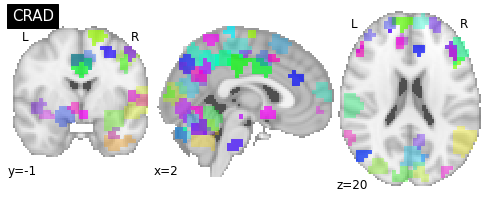

In [77]:
# Plot atlas
display = plotting.plot_prob_atlas(atlas_filename_crad, view_type='continuous', draw_cross=False, title="CRAD")
# Save atlas plot
display.savefig('../Analysis_Data/CRAD.png')

### Feature extraction for computing correlation matrices

In [ ]:
# Define function for initializing map masker (used for probabilistic atlases)
def mask_init_maps(atlas):
    masker = NiftiMapsMasker(maps_img=atlas, standardize=True, 
                           memory='nilearn_cache', verbose=0)
    return masker

In [ ]:
from nilearn.input_data import NiftiMapsMasker

# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series_CRAD_all, ind_matrices_CRAD_all = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix

In [ ]:
# Identify subject index
subject = 40

# Mask out major diagonal
np.fill_diagonal(ind_matrices_CRAD_all[subject], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_CRAD_all[subject], figure=(10, 8),   
                     labels=range(time_series_CRAD_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/CRAD_corr.png')

### Plot connectome

In [ ]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_filename_crad)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_CRAD_all[subject], coordinates,
                         edge_threshold="80%",
                         title='CRAD Atlas (probabilistic)')
# Save connectome plot
display.savefig('../Analysis_Data/CRAD_connectome.png')

### Perform SVR analysis

In [ ]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features_CRAD_all = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [ ]:
#sio.savemat('atlas3.mat', {'y_pred_all2': y_pred_all[k], 'y_train_container2': np.array(y_train_container)[k][y_index_all[k]]})


## Linear decomposition methods atlas

### Load MSDL atlas

In [ ]:
# Load atlas
parcellations_msdl = datasets.fetch_atlas_msdl(data_dir='../Original_Data')
atlas_filename_msdl = parcellations_msdl.maps

In [ ]:
# Save state of DataLad dataset
#api.save(path='../Original_Data/msdl_atlas', message='Download MSDL atlas')

### Plot atlas

In [ ]:
# Plot atlas
display = plotting.plot_prob_atlas(atlas_filename_msdl, view_type='continuous', draw_cross=False, title="MSDL")
# Save atlas plot
display.savefig('../Analysis_Data/MSDL.png')

### Feature extraction for computing correlation matrices

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=False)

# Extract features for generatin of individual correlation matrices
time_series_MSDL_all, ind_matrices_MSDL_all = feat_extract_corr(masker, correlation_measure)

### Plot correlation matrix

In [ ]:
# Mask out major diagonal
np.fill_diagonal(ind_matrices_MSDL_all[40], 0)
# Plot correlation matrix
display = plotting.plot_matrix(ind_matrices_MSDL_all[40], figure=(10, 8),   
                     labels=range(time_series_MSDL_all.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False)
# Save correlation matrix
display.figure.savefig('../Analysis_Data/MSDL_corr.png')

### Plot connectome

In [ ]:
# Identify center coordinates for atlas labels
coordinates = plotting.find_probabilistic_atlas_cut_coords(maps_img=atlas_filename_msdl)

# Plot connectome with 80% edge strength
display = plotting.plot_connectome(ind_matrices_MSDL_all[subject], coordinates,
                         edge_threshold="80%",
                         title='MSDL Atlas (probabilistic)')
# Save connectome plot
display.savefig('../Analysis_Data/MSDL_connectome.png')

### Perform SVR analysis

In [ ]:
# Initialize connectivity measure
correlation_measure = corr_measure(diag=True)

# Extract features for model
X_features_MSDL_all = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

In [ ]:
#sio.savemat('atlas4.mat', {'y_pred_all3': y_pred_all[k], 'y_train_container3': np.array(y_train_container)[k][y_index_all[k]]})


# Explore confounds

## Functional atlas-CSF

### Load all confounds as dataframes

In [ ]:
for filename in data.confounds:
    df = pd.read_csv(filename, sep='\t')
    all_conf.append(df)

In [ ]:
# Define function to extract features for support vector regression model using confound option
def feat_extract_model_confounds(masker, correlation_measure, confounds, conf_type):
    all_features = [] # Empty list for containing all features (correlations)
    
    if conf_type == 'CSF':
        drop_list = ['white_matter','global_signal']
    elif conf_type == 'WM':
        drop_list = ['csf','global_signal']
    elif conf_type == 'global':
        drop_list = ['csf','white_matter']
    elif conf_type == 'motion':
        drop_list = ['framewise_displacement']
        
    # Extract signal based on labels defined by atlas
    for i,sub in enumerate(data.func):
        # Extract timeseries from each ROI in atlas
        time_series = masker.fit_transform(sub, confounds=confounds[i].drop(drop_list, axis=1).to_numpy())
        # Create region x region correlation matrix
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]
        # Add correlation matrix to feature container
        all_features.append(correlation_matrix)
        # Track progress
        #print('finished %s of %s'%(i+1,len(data.func)))
        
        # Convert feature list to numpy array
        X_features = np.array(all_features)
        
    return X_features

### Perform SVR analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Functional atlas-white matter

### Perform SVR analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Functional atlas-global signal

### Perform SVR Analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Functional atlas-motion

### Perform SVR analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_basc)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_BASC_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_BASC_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-CSF

### Perform SVR Analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-white matter

### Perform SVR Analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-global signal

### Perform SVR Analysis

In [ ]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

## Structural atlas-motion

### Perform SVR Analysis

In [78]:
# Initialize masker and connectivity measure
masker = mask_init_labels(atlas=atlas_filename_aal)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_AAL_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_AAL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_labels' is not defined

## Clustering method atlas-CSF

### Perform SVR Analysis

In [79]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

## Clustering method atlas-white matter

### Perform SVR Analysis

In [80]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

## Clustering method atlas-global signal

### Perform SVR Analysis

In [81]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

## Clustering method atlas-motion

### Perform SVR Analysis

In [82]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_crad)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_CRAD_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_CRAD_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

In [ ]:
import plotly.express as px
import pandas as pd
#y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]]
df = pd.DataFrame(dict(R1=y_pred_all[k], NOS=np.array(y_train_container)[k][y_index_all[k]]))
px.scatter(df, x="R1", y="NOS" ,labels={'x':'R1', 'y':'NOS'}, trendline="ols").show()


## Linear decomposition methods atlas-CSF

### Perform SVR Analysis

In [83]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_CSF = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

## Linear decomposition methods atlas-white matter

### Perform SVR Analysis

In [84]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_WM = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

## Linear decomposition methods atlas-global signal

### Perform SVR Analysis

In [85]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_global = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

## Linear decomposition methods atlas-motion

### Perform SVR Analysis

In [86]:
# Initialize masker and connectivity measure
masker = mask_init_maps(atlas=atlas_filename_msdl)
correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
X_features_MSDL_motion = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train_container, X_val_container, y_train_container, y_val_container = train_val(X_features_MSDL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_index_all, y_pred_all = model_fit(X_train_container, y_train_container)

# Evaluate model using accuracy and mean absolute error
# Choose fold to visualize
k = 9

sns.regplot(y_pred_all[k], np.array(y_train_container)[k][y_index_all[k]])
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')
plt.title('Result for fold {}'.format(k))

# Compute mean accuracy and mean mae for all 10 folds
mean_acc = []
mean_mae = []

for fold in np.arange(0, 10, 1).tolist():
    mean_acc.append(r2_score(np.array(y_train_container)[k][y_index_all[k]], y_pred_all[k]))
    mean_mae.append(mean_absolute_error(np.array(y_train_container)[k][y_index_all[k]],y_pred_all[k]))
    
print('Mean R2:',sum(mean_acc) / len(mean_acc))
print('Mean MAE:',sum(mean_mae) / len(mean_mae))

NameError: name 'mask_init_maps' is not defined

In [ ]:
from datalad import api

api.save(path='../Analysis_Data', message='Add all .csv files generated for confound analysis to Analysis_Data')


# Test model on unseen data

In [87]:
def train_val_final(X_features, y_age, age_class):
    X_train, X_val, y_train, y_val = train_test_split(
                                                        X_features, # x
                                                        y_age, # y
                                                        test_size = 0.25, # 60%/40% split  
                                                        shuffle = True, # shuffle dataset
                                                                        # before splitting
                                                        stratify = age_class,  # keep
                                                                               # distribution
                                                                               # of ageclass
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                        random_state = 123 # same shuffle each
                                                                           # time
                                                                           )
    return X_train, X_val, y_train, y_val

In [88]:
def model_fit_final(X_train, X_val, y_train):
    # Build a tiny pipeline that does feature selection (top 20% of features), 
    # and then prediction with our linear svr model.
    model = Pipeline([
        ('feature_selection',SelectPercentile(f_regression,percentile=20)),
        ('prediction', l_svr)
                     ])
    
    # Run pipeline 
    model.fit(X_train, y_train) # Fit data to the model using mini pipeline
    y_pred = model.predict(X_val)
        
    return y_pred

### Create empty dictionary for output

In [89]:
output = { 'BASC': 
           { 'All': { 'y_pred': {}, 'y_val': {}},  
           'CSF': { 'y_pred': {}, 'y_val': {}},
           'WM': { 'y_pred': {}, 'y_val': {}},
           'Global': { 'y_pred': {}, 'y_val': {}},
           'Motion': { 'y_pred': {}, 'y_val': {}}},  
          'AAL': 
          { 'All': { 'y_pred': {}, 'y_val': {}},  
            'CSF': { 'y_pred': {}, 'y_val': {}},
            'WM': { 'y_pred': {}, 'y_val': {}},
            'Global': { 'y_pred': {}, 'y_val': {}},
            'Motion': { 'y_pred': {}, 'y_val': {}}},
          'CRAD': 
          { 'All': { 'y_pred': {}, 'y_val': {}},  
            'CSF': { 'y_pred': {}, 'y_val': {}},
            'WM': { 'y_pred': {}, 'y_val': {}},
            'Global': { 'y_pred': {}, 'y_val': {}},
            'Motion': { 'y_pred': {}, 'y_val': {}}},
         'MSDL': 
          { 'All': { 'y_pred': {}, 'y_val': {}},  
            'CSF': { 'y_pred': {}, 'y_val': {}},
            'WM': { 'y_pred': {}, 'y_val': {}},
            'Global': { 'y_pred': {}, 'y_val': {}},
            'Motion': { 'y_pred': {}, 'y_val': {}}}}

## Functional atlas

### Perform SVR Analysis-all confounds

In [90]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['All']['y_pred'] = y_pred
output['BASC']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_BASC_all' is not defined

### Perform SVR Analysis-CSF

In [91]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['CSF']['y_pred'] = y_pred
output['BASC']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_BASC_CSF' is not defined

### Perform SVR Analysis-WM

In [92]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['WM']['y_pred'] = y_pred
output['BASC']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_BASC_WM' is not defined

### Perform SVR Analysis-global

In [93]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['Global']['y_pred'] = y_pred
output['BASC']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_BASC_global' is not defined

### Perform SVR Analysis-motion

In [94]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_basc)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_BASC_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['BASC']['Motion']['y_pred'] = y_pred
output['BASC']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_BASC_motion' is not defined

## Structural atlas

### Perform SVR Analysis-all confounds

In [95]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['All']['y_pred'] = y_pred
output['AAL']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_AAL_all' is not defined

### Perform SVR Analysis-CSF

In [96]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['CSF']['y_pred'] = y_pred
output['AAL']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_AAL_CSF' is not defined

### Perform SVR Analysis-WM

In [97]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['WM']['y_pred'] = y_pred
output['AAL']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_AAL_WM' is not defined

### Perform SVR Analysis-global

In [98]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['Global']['y_pred'] = y_pred
output['AAL']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_AAL_global' is not defined

### Perform SVR Analysis-motion

In [99]:
# Initialize masker and connectivity measure
#masker = mask_init_labels(atlas=atlas_filename_aal)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_AAL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['AAL']['Motion']['y_pred'] = y_pred
output['AAL']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_AAL_motion' is not defined

## Clustering method atlas

### Perform SVR Analysis-all confounds

In [100]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['All']['y_pred'] = y_pred
output['CRAD']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_CRAD_all' is not defined

### Perform SVR Analysis-CSF

In [101]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['CSF']['y_pred'] = y_pred
output['CRAD']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_CRAD_CSF' is not defined

### Perform SVR Analysis-WM

In [102]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['WM']['y_pred'] = y_pred
output['CRAD']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_CRAD_WM' is not defined

### Perform SVR Analysis-global

In [103]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['Global']['y_pred'] = y_pred
output['CRAD']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_CRAD_global' is not defined

### Perform SVR Analysis-motion

In [104]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_crad)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_CRAD_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['CRAD']['Motion']['y_pred'] = y_pred
output['CRAD']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_CRAD_motion' is not defined

## Linear decomposition method atlas

### Perform SVR Analysis-all confounds

In [105]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model(masker, correlation_measure)

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_all, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['All']['y_pred'] = y_pred
output['MSDL']['All']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_MSDL_all' is not defined

### Perform SVR Analysis-CSF

In [106]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'CSF')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_CSF, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['CSF']['y_pred'] = y_pred
output['MSDL']['CSF']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_MSDL_CSF' is not defined

### Perform SVR Analysis-WM

In [107]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'WM')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_WM, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['WM']['y_pred'] = y_pred
output['MSDL']['WM']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_MSDL_WM' is not defined

### Perform SVR Analysis-global

In [108]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'global')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_global, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['Global']['y_pred'] = y_pred
output['MSDL']['Global']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_MSDL_global' is not defined

### Perform SVR Analysis-motion

In [109]:
# Initialize masker and connectivity measure
#masker = mask_init_maps(atlas=atlas_filename_msdl)
#correlation_measure = corr_measure(diag=True)

# Extract features for SVR analysis
#X_features = feat_extract_model_confounds(masker, correlation_measure, all_conf, 'motion')

# Generate training/validation splits
X_train, X_val, y_train, y_val = train_val_final(X_features_MSDL_motion, y_age, age_class)

# Fit model to training data using 10-fold CV
y_pred = model_fit_final(X_train, X_val, y_train)

output['MSDL']['Motion']['y_pred'] = y_pred
output['MSDL']['Motion']['y_val'] = y_val.to_numpy()

# Assess model performance
acc = r2_score(y_val, y_pred) # get accuracy (r2)
mae = mean_absolute_error(y_val, y_pred) # get mae

# print results
print('R2:', acc)
print('MAE:',mae)

NameError: name 'X_features_MSDL_motion' is not defined

In [110]:
# Save results for interactive figure
sio.savemat('../Analysis_Data/output.mat', output);

NameError: name 'sio' is not defined